# Investigate the 3 weird WCS corrections on Oct 16th and one on Oct 17th

DIDs:
- 0350160620 [-593, -227]
- 0350160621 [-592, -114]
- 0350160622 [-601, -65]
- 0350170603

Plan of Attack
- Load icnt and corresponding HMI image
- recompute the error manually to confirm
- investigate error on smaller subsections of the HRT frame

Results
- Even normalising the HMI remapped images does not affect the weird results
- the maximum of the fft output sems to be in a global minimum, but near the edges there are maximums which sometimes are higher than the maximum in the centre
- could try to restrict the image_register method to only take argmax within the central strip..., but would artificially be setting a bounding box/upper limits on the allowed shift between images

In [2]:
import sys
sys.path.append('../')

In [ ]:
import os
import numpy as np 
from astropy.io import fits
import matplotlib.pyplot as plt
import sunpy
import sunpy.map
import _pickle as cPickle
from src.reproject_funcs import *

/scratch/slam/sinjan/.conda/envs/p310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
hrt_dir16='/data/solo/phi/data/fmdb/public/l2/2023-10-16/'
hmi_blos_45_dir='/data/slam/sinjan/arlongterm_hmi/blos_45/'
hmi_ic_45_dir='/data/slam/sinjan/arlongterm_hmi/ic_45/'

# 0350160620

In [3]:
hrt1 = hrt_dir16+'solo_L2_phi-hrt-icnt_20231016T191503_V202408291137_0350160620.fits.gz'
data1=fits.getdata(hrt1)

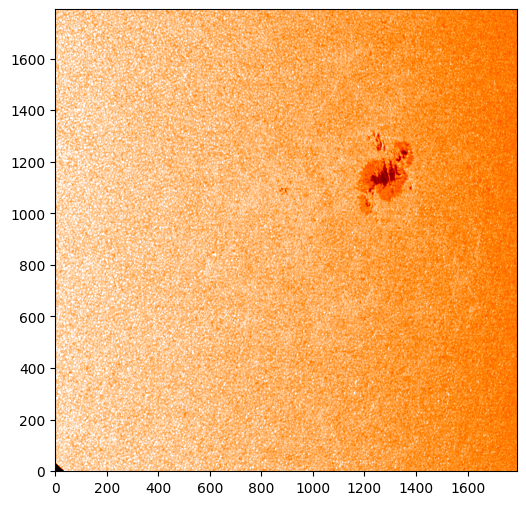

In [9]:
plt.figure(figsize=(6,6))
plt.imshow(data1,origin="lower",cmap='gist_heat',vmin=0,vmax=1.2)
plt.show()

In [4]:
hmi1=hmi_ic_45_dir+'hmi.ic_45s.20231016_192100_TAI.2.continuum.fits'

In [12]:
crval_err,crpix_err = get_hrt_wcs_crval_err(hrt1,hmi1,save_crpix_err=True)

/data/solo/phi/data/fmdb/public/l2/2023-10-16/solo_L2_phi-hrt-icnt_20231016T191503_V202408291137_0350160620.fits.gz
/data/slam/sinjan/arlongterm_hmi/ic_45/hmi.ic_45s.20231016_192100_TAI.2.continuum.fits


4096/4096 done234639037.0

[-227, -592]


In [13]:
print(crval_err,crpix_err)

(-282.51371249723275, -143.8202923304828) (-592, -227)


In [5]:
h=fits.getheader(hrt1)
hrt_map = sunpy.map.Map(fits.getdata(hrt1),h)
hmi_map = sunpy.map.Map(hmi1)

In [6]:
hmi_remap = hmi2phi(hmi_map, hrt_map)

4096/4096 done234639037.0



In [31]:
hmi_remap.data.shape

(1792, 1792)

In [62]:
hrt_map.data.shape

(1792, 1792)

In [48]:
norm_hmi = hmi_remap.data.mean()

In [7]:
startx,endx=0,1900 #1777 is the start point for the problems in x, and endy=1780 - so it's the last few columns
starty,endy=0,1900

In [8]:
r,s = image_register(hmi_remap.data[starty:endy,startx:endx],hrt_map.data[starty:endy,startx:endx], False, False)
print(s)

x_HRT=h['CRPIX1']
y_HRT=h['CRPIX2']

x_HMI=h['CRPIX1']-s[1]
y_HMI=h['CRPIX2']-s[0]

feature_coordshrt = hrt_map.pixel_to_world(x_HRT * u.pixel, y_HRT * u.pixel)
feature_coordshmi = hmi_remap.pixel_to_world(x_HMI * u.pixel, y_HMI * u.pixel)

errx=feature_coordshrt.Tx.value-feature_coordshmi.Tx.value
erry=feature_coordshrt.Ty.value-feature_coordshmi.Ty.value

print(errx,erry)

[190, 2]
-8.936362121535694 94.58403374115014


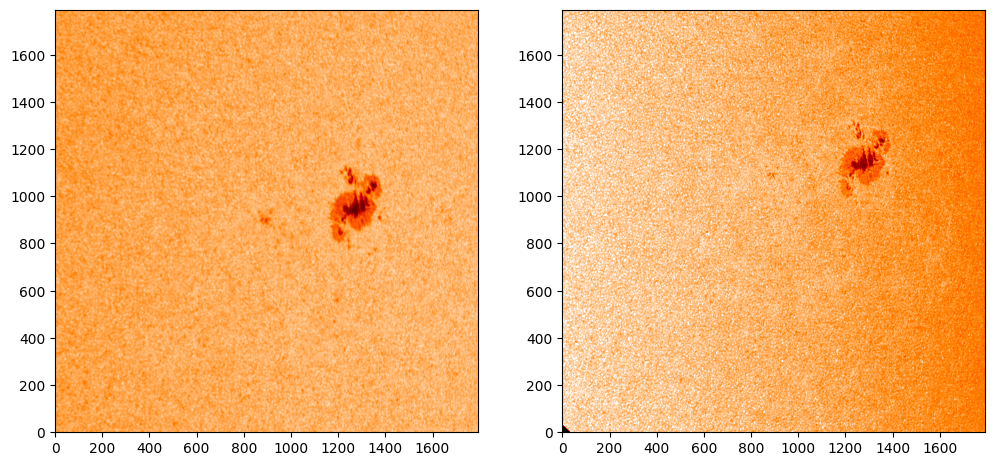

In [113]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(hmi_remap.data[starty:endy,startx:endx]/norm_hmi,origin="lower",cmap='gist_heat',vmin=0,vmax=1.2)
#plt.colorbar()

plt.subplot(122)
plt.imshow(hrt_map.data[starty:endy,startx:endx],origin="lower",cmap='gist_heat',vmin=0,vmax=1.2)
plt.show()

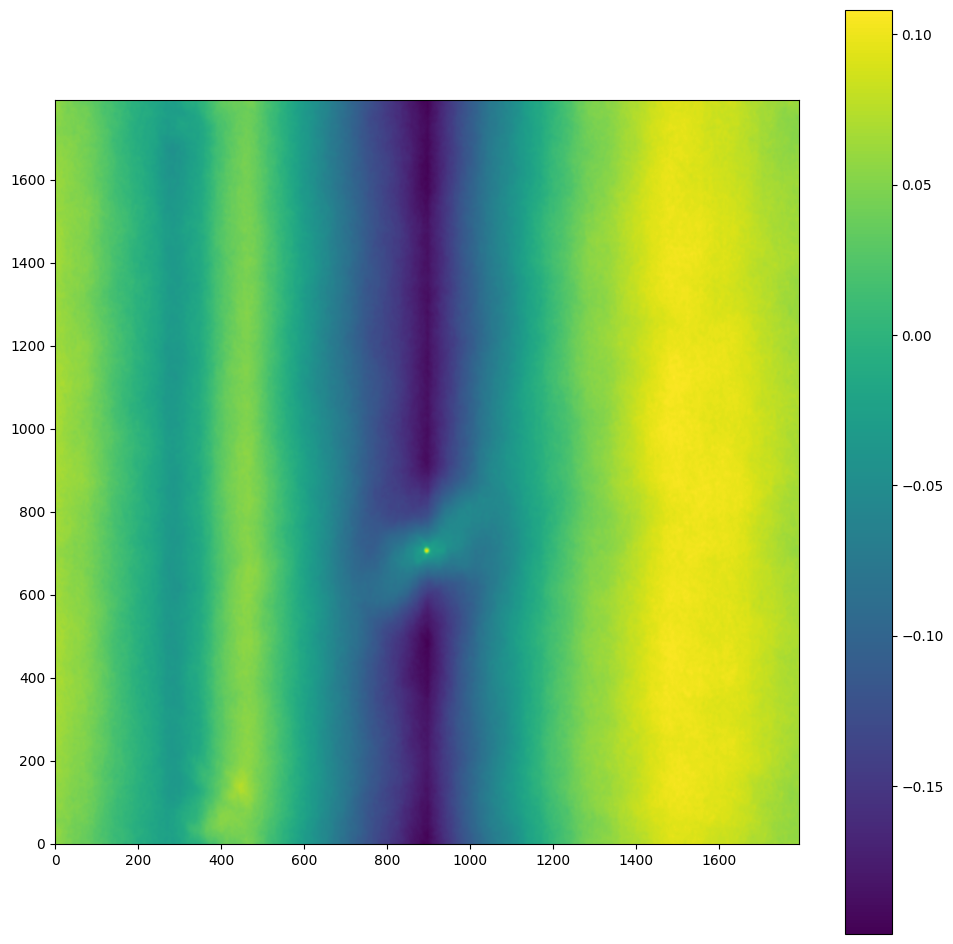

In [9]:
plt.figure(figsize=(12,12))
plt.imshow(r,origin="lower")
plt.colorbar()
plt.show()

In [110]:
np.max(r[:,1100:])

0.10498354880066602

In [104]:
ss = r.shape
index = np.unravel_index(np.argmax(r),ss)

In [105]:
index

(706, 884)

In [106]:
[(ss[0]//2-(index[0])),(ss[1]//2-(index[1]))]

[190, 2]

In [107]:
ss[1]//2

886

# 0350160621

In [16]:
hrt2 = hrt_dir16+'solo_L2_phi-hrt-icnt_20231016T201503_V202408291137_0350160621.fits.gz'
hmi2 = hmi_ic_45_dir+'hmi.ic_45s.20231016_202100_TAI.2.continuum.fits'

crval_err,crpix_err = get_hrt_wcs_crval_err(hrt2,hmi2,save_crpix_err=True)
print(crval_err,crpix_err)

/data/solo/phi/data/fmdb/public/l2/2023-10-16/solo_L2_phi-hrt-icnt_20231016T201503_V202408291137_0350160621.fits.gz
/data/slam/sinjan/arlongterm_hmi/ic_45/hmi.ic_45s.20231016_202100_TAI.2.continuum.fits


4096/4096 done232731717.0

[193, -1]
(-10.55262782291129, 95.9225761165161) (-1, 193)


# 0350160622

In [17]:
hrt3 = hrt_dir16+'solo_L2_phi-hrt-icnt_20231016T211503_V202408291137_0350160622.fits.gz'
hmi3 = hmi_ic_45_dir+'hmi.ic_45s.20231016_212100_TAI.2.continuum.fits'

crval_err,crpix_err = get_hrt_wcs_crval_err(hrt3,hmi3,save_crpix_err=True)
print(crval_err,crpix_err)

/data/solo/phi/data/fmdb/public/l2/2023-10-16/solo_L2_phi-hrt-icnt_20231016T211503_V202408291137_0350160622.fits.gz
/data/slam/sinjan/arlongterm_hmi/ic_45/hmi.ic_45s.20231016_212100_TAI.2.continuum.fits


4096/4096 done230864740.0

[187, -2]
(-10.705830385895979, 92.89043580449598) (-2, 187)


# 0350170603

In [18]:
hrt_dir17 = '/data/solo/phi/data/fmdb/public/l2/2023-10-17/'

In [19]:
hrt4 = hrt_dir17+'solo_L2_phi-hrt-icnt_20231017T021503_V202408291137_0350170603.fits.gz'
hmi4 = hmi_ic_45_dir+'hmi.ic_45s.20231017_022100_TAI.2.continuum.fits'

crval_err,crpix_err = get_hrt_wcs_crval_err(hrt4,hmi4,save_crpix_err=True)
print(crval_err,crpix_err)

/data/solo/phi/data/fmdb/public/l2/2023-10-17/solo_L2_phi-hrt-icnt_20231017T021503_V202408291137_0350170603.fits.gz
/data/slam/sinjan/arlongterm_hmi/ic_45/hmi.ic_45s.20231017_022100_TAI.2.continuum.fits


4096/4096 done221481305.0

[180, 4]
(-7.205379378667658, 89.73339194964097) (4, 180)


# Control Test

In [11]:
hrt_control=hrt_dir16+'solo_L2_phi-hrt-icnt_20231016T001503_V202408291137_0350160601.fits.gz'
hmi_control=hmi_ic_45_dir+'hmi.ic_45s.20231016_002100_TAI.2.continuum.fits'

hc=fits.getheader(hrt_control)
hrt_cmap = sunpy.map.Map(fits.getdata(hrt_control),hc)
hmi_cmap = sunpy.map.Map(hmi_control)

In [12]:
hmi_cremap = hmi2phi(hmi_cmap, hrt_cmap)

4096/4096 done273317188.0



In [13]:
startx,endx=0,1900
starty,endy=0,1900

In [14]:
rc,sc = image_register(hmi_cremap.data[starty:endy,startx:endx],hrt_cmap.data[starty:endy,startx:endx], False, False)
print(sc)

x_HRT=h['CRPIX1']
y_HRT=h['CRPIX2']

x_HMI=h['CRPIX1']-sc[1]
y_HMI=h['CRPIX2']-sc[0]

feature_coordshrt = hrt_map.pixel_to_world(x_HRT * u.pixel, y_HRT * u.pixel)
feature_coordshmi = hmi_remap.pixel_to_world(x_HMI * u.pixel, y_HMI * u.pixel)

errx=feature_coordshrt.Tx.value-feature_coordshmi.Tx.value
erry=feature_coordshrt.Ty.value-feature_coordshmi.Ty.value

print(errx,erry)

[188, 8]
-5.848262742577617 93.9031194959492


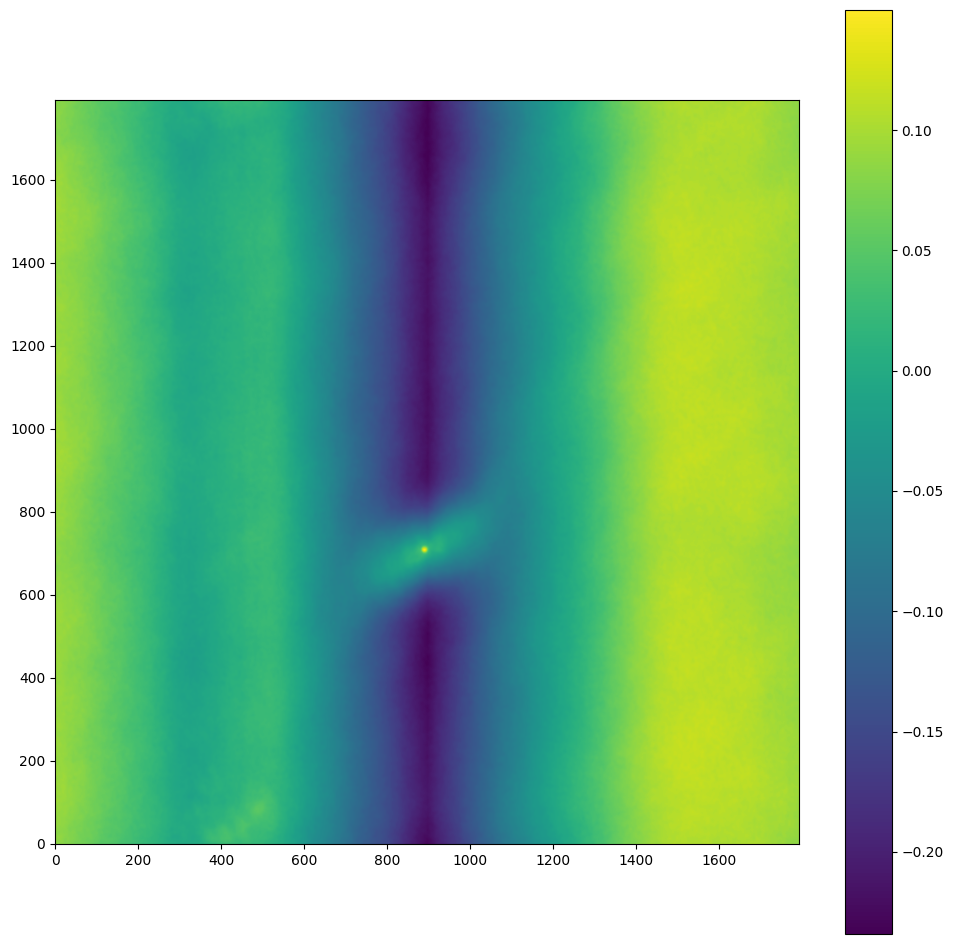

In [15]:
plt.figure(figsize=(12,12))
plt.imshow(rc,origin="lower")
plt.colorbar()
plt.show()